In [1]:
from typing import Union, Any, Optional, Callable, Tuple
from abc import ABC, abstractmethod
import eagerpy as ep

from foolbox.devutils import flatten
from foolbox.devutils import atleast_kd

from foolbox.types import Bounds

from foolbox.models.base import Model

from foolbox.criteria import Misclassification, TargetedMisclassification

from foolbox.distances import l1, l2, linf

from foolbox.attacks.base import FixedEpsilonAttack
from foolbox.attacks.base import T
from foolbox.attacks.base import get_criterion
from foolbox.attacks.base import raise_if_kwargs

def _get_loss_fn(self, model: Model, labels: ep.Tensor, original_lengths=None) -> Callable[[ep.Tensor], ep.Tensor]:
    # can be overridden by users
    def loss_fn(inputs: ep.Tensor, original_lengths) -> ep.Tensor:
        logits = model(inputs, original_lengths)
        return ep.crossentropy(logits, labels).sum()

    return loss_fn

def _value_and_grad(
    # can be overridden by users
    self,
    loss_fn: Callable[[ep.Tensor], ep.Tensor],
    x: ep.Tensor,
    original_lengths: ep.Tensor,
) -> Tuple[ep.Tensor, ep.Tensor]:
    return ep.value_and_grad(loss_fn, x, original_lengths)

def _run(
    self,
    model: Model,
    inputs: T,
    criterion: Union[Misclassification, TargetedMisclassification, T],
    *,
    epsilon: float,
    **kwargs: Any,
) -> T:
#     raise_if_kwargs(kwargs)
    x0, restore_type = ep.astensor_(inputs)
    criterion_ = get_criterion(criterion)
    original_lengths = kwargs['original_lengths']
    del inputs, criterion, kwargs

    # perform a gradient ascent (targeted attack) or descent (untargeted attack)
    if isinstance(criterion_, Misclassification):
        gradient_step_sign = 1.0
        classes = criterion_.labels
    elif hasattr(criterion_, "target_classes"):
        gradient_step_sign = -1.0
        classes = criterion_.target_classes  # type: ignore
    else:
        raise ValueError("unsupported criterion")

    loss_fn = self.get_loss_fn(model, classes)

    if self.abs_stepsize is None:
        stepsize = self.rel_stepsize * epsilon
    else:
        stepsize = self.abs_stepsize

    if self.random_start:
        x = self.get_random_start(x0, epsilon)
        x = ep.clip(x, *model.bounds)
    else:
        x = x0

    for _ in range(self.steps):
        _, gradients = self.value_and_grad(loss_fn, x, original_lengths) #!!!!
        gradients = self.normalize(gradients, x=x, bounds=model.bounds)
        x = x + gradient_step_sign * stepsize * gradients
        x = self.project(x, x0, epsilon)
        x = ep.clip(x, *model.bounds)

    return restore_type(x)

In [2]:
import warnings
warnings.filterwarnings('ignore')

import sys
pkg_path = "/nfs/homedirs/yuny/project-1/audio_classification"
if pkg_path not in sys.path:
    sys.path.append(pkg_path)

pkg_path = "/nfs/homedirs/yuny/project-1/foolbox"
if pkg_path not in sys.path:
    sys.path.append(pkg_path)

import time
import types
import yaml
import torch
from audio_classification.tools import do_train, get_dataloader, get_model, get_transform
from audio_classification.tools.train_net import collate
from audio_classification.model import lit_m11, LitCRNN
from audio_classification.data import BMWDataset

from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import LinfPGD, L2PGD, FGM, FGSM, L2AdditiveGaussianNoiseAttack, L2AdditiveUniformNoiseAttack, L2ClippingAwareAdditiveGaussianNoiseAttack, L2ClippingAwareAdditiveUniformNoiseAttack

from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Training on device cuda.


In [3]:
# instantiate a model 
torch.cuda.empty_cache()
with open("/nfs/students/winter-term-2020/project-1/project-1/audio_classification/configs/crnn_bmw.yaml", "r") as config_file:
    configs = yaml.load(config_file)
path_to_checkpoint = '/nfs/homedirs/yuny/project-1/weights/' + 'bmw_week3/crnn-bmw-fold1-epoch=33-val_acc=0.984.ckpt'
model = LitCRNN.load_from_checkpoint(path_to_checkpoint, cfg=configs)
fmodel = PyTorchModel(model, bounds=(-200, 200))
# use validattion set
val_set = BMWDataset(configs, [1], transform=get_transform(configs))
val_loader = DataLoader(val_set, batch_size=10, shuffle=True,
                                num_workers=configs["DATALOADER"]["NUM_WORKERS"],
                                pin_memory=True, collate_fn = collate)
it = iter(val_loader)

/nfs/homedirs/yuny/project-1/foolbox/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


In [4]:
# evaluate accuracy on clean data on a batch
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
batch = next(it)
clips = batch[0].to(device)
labels = batch[1].to(device)
lengths = batch[2].to(device)   # used only for CRNN

In [ ]:
# Visualize adverserial sample
attack = FGM()

attack.run = types.MethodType(_run, attack)
attack.get_loss_fn = types.MethodType(_get_loss_fn, attack)
attack.value_and_grad = types.MethodType(_value_and_grad, attack)
# raw, clipped, is_adv = attack(fmodel, clips, labels, epsilons=40)
raw, clipped, is_adv = attack(fmodel, clips, labels, epsilons=40, original_lengths=lengths)

is_adv = is_adv.cpu()
clipped = clipped.cpu()

In [ ]:
idx = np.where(is_adv.cpu().numpy()==True)[0][0]
print(idx)
# Visualize attack sample
out = model(clipped.to(device), lengths)
preds = torch.argmax(out, dim=1)

idx = np.where(is_adv.cpu().numpy()==True)[0][0]
sample = clipped[idx]
print("label %s" %(preds[idx]))
print(sample[0].shape)
plt.pcolormesh(sample[0].squeeze().numpy(), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
# Visualize original sample
sample = batch[0]
print("label %s" %(batch[1][idx]))
print(sample[idx].shape)
plt.pcolormesh(sample[idx].squeeze().numpy(), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [7]:
# evaluate robustness with L-inf Fast Gradient Attack
torch.cuda.empty_cache()
attack = FGSM()

attack.run = types.MethodType(_run, attack)
attack.get_loss_fn = types.MethodType(_get_loss_fn, attack)
attack.value_and_grad = types.MethodType(_value_and_grad, attack)
epsilons = np.linspace(0.0, 100, num=100)

start_time = time.perf_counter()
raw, clipped, is_adv = attack(fmodel, clips, labels, epsilons=epsilons, original_lengths=lengths)
end_time = time.perf_counter()
print(f"Generated attacks in {end_time - start_time:0.2f} seconds")

robust_accuracy = 1 - is_adv.double().mean(axis=-1)

Generated attacks in 11.19 seconds


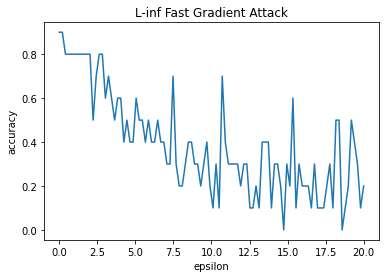

In [8]:
plt.title("L-inf Fast Gradient Attack")
plt.xlabel("epsilon")
plt.ylabel("accuracy")
plt.plot(epsilons, robust_accuracy.to('cpu').numpy())

In [11]:
# evaluate robustness with L-2 Fast Gradient Attack
torch.cuda.empty_cache()
attack = FGM()

attack.run = types.MethodType(_run, attack)
attack.get_loss_fn = types.MethodType(_get_loss_fn, attack)
attack.value_and_grad = types.MethodType(_value_and_grad, attack)
epsilons = np.linspace(0.0, 100, num=100)

start_time = time.perf_counter()
raw, clipped, is_adv = attack(fmodel, clips, labels, epsilons=epsilons, original_lengths=lengths)
end_time = time.perf_counter()
print(f"Generated attacks in {end_time - start_time:0.2f} seconds")

robust_accuracy = 1 - is_adv.double().mean(axis=-1)

Generated attacks in 11.21 seconds


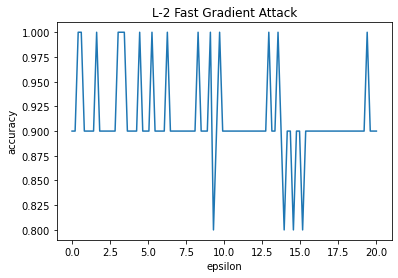

In [12]:
plt.title("L-2 Fast Gradient Attack")
plt.xlabel("epsilon")
plt.ylabel("accuracy")
plt.plot(epsilons, robust_accuracy.to('cpu').numpy())